In [1]:
%matplotlib inline
from math import pi
import openmc
import openmc.deplete
import matplotlib.pyplot as plt

Let's use the same material definition as the existing pincell depletion example 

In [2]:
# Instantiate some Materials and register the appropriate Nuclides
uo2 = openmc.Material(name='UO2 fuel at 2.4% wt enrichment')
uo2.set_density('g/cm3', 10.29769)
uo2.add_element('U', 1., enrichment=2.4)
uo2.add_element('O', 2.)

helium = openmc.Material(name='Helium for gap')
helium.set_density('g/cm3', 0.001598)
helium.add_element('He', 2.4044e-4)

zircaloy = openmc.Material(name='Zircaloy 4')
zircaloy.set_density('g/cm3', 6.55)
zircaloy.add_element('Sn', 0.014, 'wo')
zircaloy.add_element('Fe', 0.00165, 'wo')
zircaloy.add_element('Cr', 0.001, 'wo')
zircaloy.add_element('Zr', 0.98335, 'wo')

borated_water = openmc.Material(name='Borated water')
borated_water.set_density('g/cm3', 0.740582)
borated_water.add_element('B', 4.0e-5)
borated_water.add_element('H', 5.0e-2)
borated_water.add_element('O', 2.4e-2)
borated_water.add_s_alpha_beta('c_H_in_H2O')

# Define overall material
material = openmc.Materials([uo2, helium, zircaloy, borated_water])

The geometry definition is going to be slightly different. Firstly, we want to bound the geometry in `z` assigning a pincell height. Secondly, we want to define a cell that contains a universe made of water and helium cells, separated by an interface, which we can initially set at $-59\ cm$ so that the initial condition of $k_{eff} \sim 1$ is satisfied. 

Filling the `msr` cell with a universe is the requirement to use the msr batchwise geometrical scheme as we will see later on.    

In [3]:
# Define surfaces
width = 1.25984
height = 200
fuel_or = openmc.ZCylinder(r=0.39218, name='Fuel OR')
clad_ir = openmc.ZCylinder(r=0.40005, name='Clad IR')
clad_or = openmc.ZCylinder(r=0.45720, name='Clad OR')
wat_or = openmc.ZCylinder(r=width/2, name='H2O OR', boundary_type='reflective')
interface = openmc.ZPlane(z0=-59, name='IF')
z_top = openmc.ZPlane(z0=height/2, name='Pin TOP', boundary_type='vacuum')
z_bot = openmc.ZPlane(z0=-height/2, name='Pin BOT', boundary_type='vacuum')

# Define cells
fuel = openmc.Cell(fill=uo2, region=-fuel_or & -z_top & +z_bot)
gap = openmc.Cell(fill=helium, region=+fuel_or & -clad_ir & -z_top & +z_bot)
clad = openmc.Cell(fill=zircaloy, region=+clad_ir & -clad_or & -z_top & +z_bot)
water = openmc.Cell(fill=borated_water, region=+clad_or & -interface )
gas = openmc.Cell(fill=helium, region=+clad_or & +interface)
msr_uni = openmc.Universe(cells=(water, gas))
msr = openmc.Cell(name="MSR", fill=msr_uni, region=-wat_or & -z_top & +z_bot)
# Define overall geometry
geometry = openmc.Geometry([fuel, gap, clad, msr])

In [4]:
# Set material volume for depletion.
uo2.volume = pi * fuel_or.r**2 * height

In [5]:
# Instantiate a Settings object, set all runtime parameters, and export to XML
settings = openmc.Settings()
settings.batches = 100
settings.inactive = 10
settings.particles = 1000

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-0.62992, -0.62992, -100, 0.62992, 0.62992, 100]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings.source = openmc.source.Source(space=uniform_dist)

#Build the model
model = openmc.Model(geometry=geometry, materials=material, settings=settings)

Let's plot the pincell. We can notice the initial interface between the borated water and helium cells.

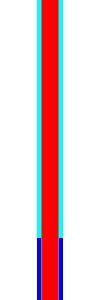

In [6]:
# Create plot
geometry.export_to_xml()
material.export_to_xml()
plot = openmc.Plot.from_geometry(geometry)
plot.basis = 'xz'
plot.width = (5,200)
plot.pixels = (100,300)
plot.color_by = 'material'
plot.colors = {uo2:'red', helium:'cyan', borated_water: 'blue', zircaloy: 'gray'}
openmc.plot_inline(plot)

We can now analazie the depletion results:

In [11]:
!rm *.h5
!rm statepoint.*.h5

#Create depletion "operator"
chain_file = 'chain_simple.xml'
# Perform simulation using the predictor algorithm
time_steps = [10.0, 10.0, 10.0, 10.0, 10.0]  # days
power = 100000  # W
#Create the depletion "operator"
op = openmc.deplete.CoupledOperator(model, chain_file)
#Create msr continuous instance
msr_c = openmc.deplete.msr.MsrContinuous(op, model)
# Set removal rate from UO2 for Xe. Default units is [sec-1]
msr_c.set_removal_rate('UO2 fuel at 2.4% wt enrichment', ['Xe'], 0.1)
#Create msr batchwise geometrical instance
msr_g = openmc.deplete.msr.MsrBatchwiseGeom(op, model, cell_id_or_name = 'MSR',
                axis=2, bracket=[-2,2], bracket_limit=[-100,100], tol=0.01, target=1.00)
# Pass the msr instance to the integrator object
integrator = openmc.deplete.PredictorIntegrator(op, time_steps, power, msr_continuous=msr_c, msr_batchwise=msr_g,  timestep_units='d')
integrator.integrate()

zsh:1: no matches found: statepoint.*.h5
[openmc.deplete] t=0.0 s, dt=864000.0 s, source=100000
Timestep: 0 --> keff: 1.00202
[openmc.deplete] t=864000.0 s, dt=864000.0 s, source=100000
Iteration: 1; Guess of -2.00e+00 produced a keff of 0.98436 +/- 0.00297
Iteration: 2; Guess of 2.00e+00 produced a keff of 1.00750 +/- 0.00308
Iteration: 3; Guess of 7.03e-01 produced a keff of 0.99270 +/- 0.00319
Iteration: 4; Guess of 1.34e+00 produced a keff of 1.00481 +/- 0.00330
Iteration: 5; Guess of 1.09e+00 produced a keff of 0.99916 +/- 0.00292
Iteration: 6; Guess of 1.13e+00 produced a keff of 1.00389 +/- 0.00375
Iteration: 7; Guess of 1.10e+00 produced a keff of 0.99948 +/- 0.00292
Iteration: 8; Guess of 1.10e+00 produced a keff of 1.00060 +/- 0.00306
UPDATE: old value: 0.00 cm --> new value: 1.10 cm
Timestep: 1 --> keff: 1.00064
[openmc.deplete] t=1728000.0 s, dt=864000.0 s, source=100000
Iteration: 1; Guess of -9.05e-01 produced a keff of 0.97407 +/- 0.00277
Iteration: 2; Guess of 3.10e+00 

Let's open the results and plot them again:

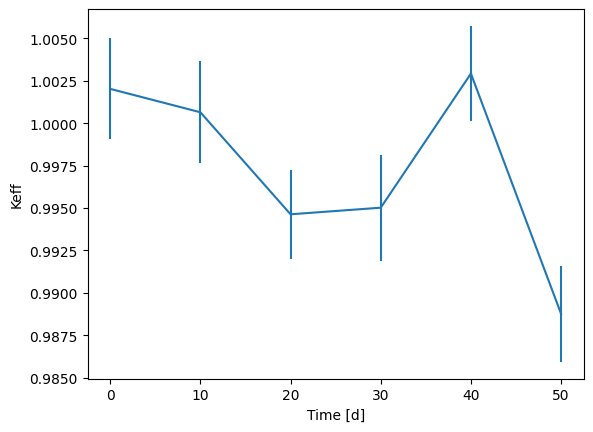

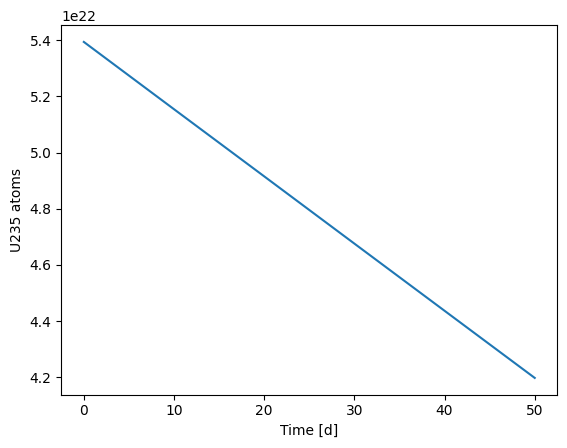

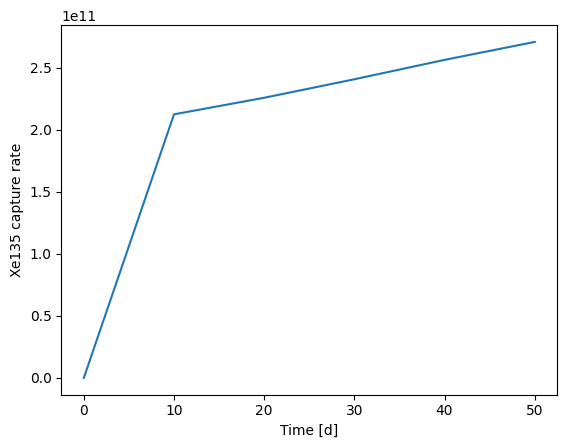

In [12]:
# Open results file
results = openmc.deplete.Results("depletion_results.h5")

# Obtain K_eff as a function of time
time, keff = results.get_keff(time_units='d')

# Obtain U235 concentration as a function of time
_, n_U235 = results.get_atoms(uo2, 'U235')

# Obtain Xe135 capture reaction rate as a function of time
_, Xe_capture = results.get_reaction_rate(uo2, 'Xe135', '(n,gamma)')

# Generate plots
fig, ax = plt.subplots()
ax.errorbar(time, keff[:, 0], keff[:, 1], label="K-effective")
ax.set_xlabel("Time [d]")
ax.set_ylabel("Keff")
plt.show()

fig, ax = plt.subplots()
ax.plot(time, n_U235, label="U235")
ax.set_xlabel("Time [d]")
ax.set_ylabel("U235 atoms")
plt.show()

fig, ax = plt.subplots()
ax.plot(time, Xe_capture, label="Xe135 capture")
ax.set_xlabel("Time [d]")
ax.set_ylabel("Xe135 capture rate")
plt.show()

As we can see, $k_{eff} \sim 1$ is kept (within statistical uncertainity), even though `Xe135`(main absorber) doesn't get removed (we didn't define any removal rates in this case). This is achieved through the raise of the water level, as we can notice by plotting the results stored in `msr_results.h5`:

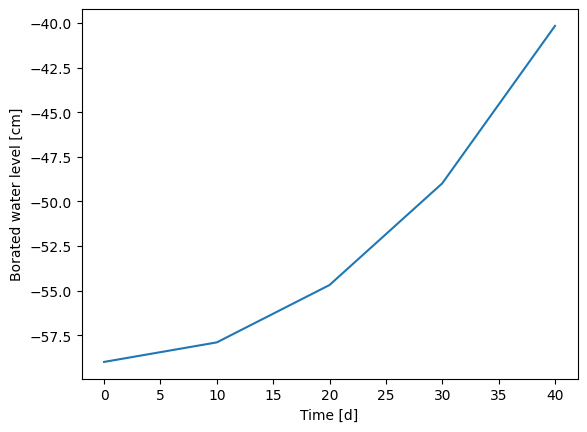

In [13]:
# To open the h5 file we need some imports
import h5py
import numpy as np
h = h5py.File('msr_results.h5','r')
vals = [] 
for key in h.keys():
    vals.append(np.array(h.get(key)))
fig, ax = plt.subplots()
# Offset the values by 59cm, our initial water level height
vals = np.cumsum(vals) - 59
ax.plot(time[:-1], vals)
ax.set_xlabel("Time [d]")
ax.set_ylabel("Borated water level [cm]")
plt.show()

In [11]:
!rm statepoint.*.h5
!rm msr_results.h5
# Reduce number of time-steps
time_steps = [10.0, 10.0, 10.0]  # days
power = 100000  # W
#Create depletion "operator"
chain_file = 'chain_simple.xml'
#Create the depletion "operator"
op = openmc.deplete.CoupledOperator(model, chain_file)
#Create msr continuous instance
msr_c = openmc.deplete.msr.MsrContinuous(op, model)
# Set removal rate from UO2 for Xe. Default units is [sec-1]
msr_c.set_removal_rate('UO2 fuel at 2.4% wt enrichment', ['Xe'], 0.1)
#Create msr batchwise geometrical instance
msr_g = openmc.deplete.msr.MsrBatchwiseGeom(op, model, cell_id_or_name = 'MSR',
                axis=2, bracket=[-2,2], bracket_limit=[-100,100], tol=0.01, target=1.00)
# Pass the msr instance to the integrator object
integrator = openmc.deplete.PredictorIntegrator(op, time_steps, power, msr_continuous=msr_c, msr_batchwise=msr_g,  timestep_units='d')
integrator.integrate()

rm: cannot remove '.xml': No such file or directory


[openmc.deplete] t=0.0 s, dt=864000.0 s, source=100000
Timestep: 0 --> keff: 1.02113
[openmc.deplete] t=864000.0 s, dt=864000.0 s, source=100000
here
Iteration: 1; Guess of 8.15e-01 produced a keff of 0.99599 +/- 0.00309
Iteration: 2; Guess of 4.82e+00 produced a keff of 1.01941 +/- 0.00372
Iteration: 3; Guess of 1.50e+00 produced a keff of 0.99459 +/- 0.00317
Iteration: 4; Guess of 3.16e+00 produced a keff of 1.00491 +/- 0.00330
Iteration: 5; Guess of 2.37e+00 produced a keff of 1.00608 +/- 0.00343
Iteration: 6; Guess of 1.91e+00 produced a keff of 1.00342 +/- 0.00308
Iteration: 7; Guess of 1.75e+00 produced a keff of 1.00475 +/- 0.00327
Iteration: 8; Guess of 1.63e+00 produced a keff of 1.00323 +/- 0.00344
Iteration: 9; Guess of 1.56e+00 produced a keff of 1.00569 +/- 0.00371
Iteration: 10; Guess of 1.53e+00 produced a keff of 0.99916 +/- 0.00305
Iteration: 11; Guess of 1.54e+00 produced a keff of 0.99834 +/- 0.00304
Iteration: 12; Guess of 1.55e+00 produced a keff of 1.00318 +/- 0.0

In [12]:
import re
import h5py
import numpy as np
# Open results file
results = openmc.deplete.Results("depletion_results.h5")
#remaining time-steps
time_steps = [10.0, 10.0]

# Get last level
with h5py.File('msr_results.h5','r') as h5:
    last_n = sorted([int(re.split('_',i)[1]) for i in h5.keys()])[-1]
    last_key = '_'.join(['geometry', str(last_n)])
    last_level = np.array(h5.get(last_key)).mean()
    setattr(msr, 'translation', [0,0,last_level])
    print(last_level)
# Define operator with restart result file
op = openmc.deplete.CoupledOperator(model, chain_file, results)
#Create msr continuous instance
msr_c = openmc.deplete.msr.MsrContinuous(op, model)
# Set removal rate from UO2 for Xe. Default units is [sec-1]
msr_c.set_removal_rate('UO2 fuel at 2.4% wt enrichment', ['Xe'], 0.1)
#Create msr batchwise geometrical instance
msr_g = openmc.deplete.msr.MsrBatchwiseGeom(op, model, cell_id_or_name = 'MSR',
                axis=2, bracket=[-2,2], bracket_limit=[-100,100], tol=0.01, target=1.00)
# Pass the msr instance to the integrator object
integrator = openmc.deplete.PredictorIntegrator(op, time_steps, power, msr_continuous=msr_c, msr_batchwise=msr_g,  timestep_units='d')


integrator.integrate()

2.7976432574215826


[openmc.deplete] t=2592000.0 s, dt=864000.0 s, source=100000
here
Iteration: 1; Guess of 7.98e-01 produced a keff of 0.97867 +/- 0.00326
Iteration: 2; Guess of 4.80e+00 produced a keff of 1.00171 +/- 0.00295
Iteration: 3; Guess of 4.50e+00 produced a keff of 0.98812 +/- 0.00305
Iteration: 4; Guess of 4.76e+00 produced a keff of 0.99472 +/- 0.00305
Iteration: 5; Guess of 4.79e+00 produced a keff of 0.99106 +/- 0.00296
UPDATE: old value: 2.80 cm --> new value: 4.80 cm
Timestep: 0 --> keff: 0.98856
[openmc.deplete] t=3456000.0 s, dt=864000.0 s, source=100000
here
Iteration: 1; Guess of 2.80e+00 produced a keff of 0.97192 +/- 0.00315
Iteration: 2; Guess of 6.80e+00 produced a keff of 0.99053 +/- 0.00332
INFO: Function returned values below or above target. Adapt bracket...
Iteration: 1; Guess of 6.80e+00 produced a keff of 0.98848 +/- 0.00299
Iteration: 2; Guess of 8.83e+00 produced a keff of 1.00246 +/- 0.00312
Iteration: 3; Guess of 8.47e+00 produced a keff of 0.99690 +/- 0.00298
Iterati

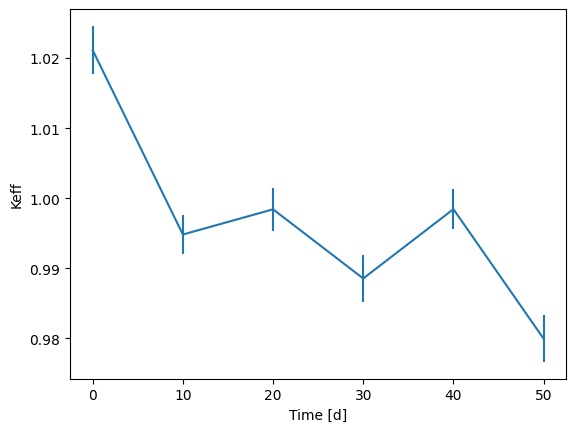

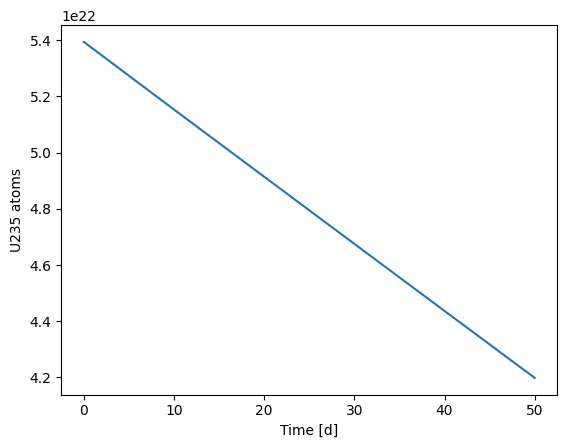

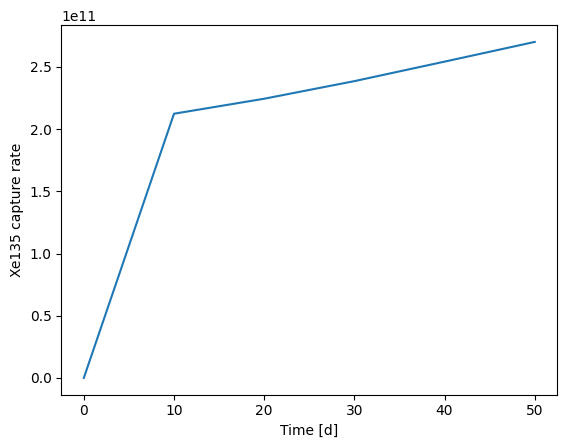

In [13]:
# Open results file
results = openmc.deplete.Results("depletion_results.h5")

# Obtain K_eff as a function of time
time, keff = results.get_keff(time_units='d')

# Obtain U235 concentration as a function of time
_, n_U235 = results.get_atoms(uo2, 'U235')

# Obtain Xe135 capture reaction rate as a function of time
_, Xe_capture = results.get_reaction_rate(uo2, 'Xe135', '(n,gamma)')

# Generate plots
fig, ax = plt.subplots()
ax.errorbar(time, keff[:, 0], keff[:, 1], label="K-effective")
ax.set_xlabel("Time [d]")
ax.set_ylabel("Keff")
plt.show()

fig, ax = plt.subplots()
ax.plot(time, n_U235, label="U235")
ax.set_xlabel("Time [d]")
ax.set_ylabel("U235 atoms")
plt.show()

fig, ax = plt.subplots()
ax.plot(time, Xe_capture, label="Xe135 capture")
ax.set_xlabel("Time [d]")
ax.set_ylabel("Xe135 capture rate")
plt.show()

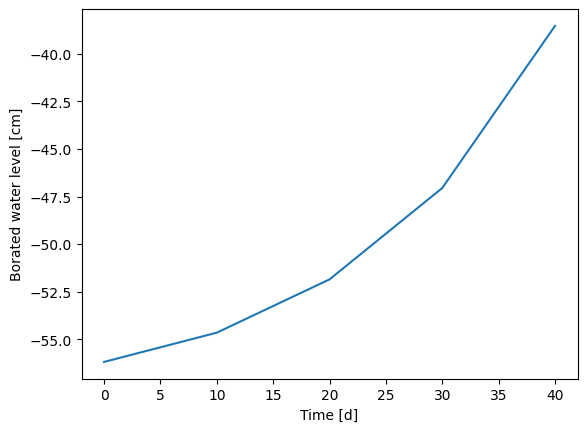

In [14]:
# To open the h5 file we need some imports
import h5py
import numpy as np
h = h5py.File('msr_results.h5','r')
vals = [] 
for key in h.keys():
    vals.append(np.array(h.get(key)))
fig, ax = plt.subplots()
# Offset the values by 59cm, our initial water level height
vals = np.cumsum(vals) - 59
ax.plot(time[:-1], vals)
ax.set_xlabel("Time [d]")
ax.set_ylabel("Borated water level [cm]")
plt.show()